In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [45]:
def normalize(df):
    """
    Normalize all features to range [0, 1], preserving LIFE_EXPECTANCY (if present).
    Assumes column names are UPPERCASE (as set by columns_treatment).
    """
    from sklearn import preprocessing
    import pandas as pd

    # Separate features from target (if present)
    try:
        x = df.drop('LIFE_EXPECTANCY', axis=1).values
    except KeyError:
        x = df.values

    # Apply MinMax scaling
    scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x)

    # Reconstruct DataFrame with same feature names (excluding LIFE_EXPECTANCY)
    df_scaled = pd.DataFrame(x_scaled, columns=df.drop(columns='LIFE_EXPECTANCY', errors='ignore').columns)

    # Add LIFE_EXPECTANCY back if it was in the original
    if 'LIFE_EXPECTANCY' in df.columns:
        df_scaled['LIFE_EXPECTANCY'] = df['LIFE_EXPECTANCY'].values

    return df_scaled


    
# def insert_into_table(conn, df, tablename):
#     curr = conn.cursor()
#     try:
#         command = f"""INSERT INTO {tablename} (""" 
#         final_part = ''
#         for idx in df.columns:
#             command = command + idx + ', '
#             final_part = final_part + '%s,'
#         command = command[:-2] + ') VALUES(' + final_part[:-1] + ')'
#         insert_into_videos = (command)
#         for i, row in df.iterrows():
#             row_to_insert = [row[column] for column in df.columns]
#             curr.execute(insert_into_videos, row_to_insert)
#     except Exception as e:
#         print(f'FALHA NO PREENCHIMENTO DA TABELA: {e}')
#         curr.execute("ROLLBACK")
#     conn.commit()

# def create_table(df, tablename, conn):
#     command = f"""CREATE TABLE {tablename} ( """
#     for idx in df.columns:
#         command += idx + ' '
#         if pd.api.types.is_integer_dtype(df[idx]):
#             command += 'INT,'
#         elif pd.api.types.is_float_dtype(df[idx]):
#             command += 'FLOAT,'
#         else:
#             command += 'VARCHAR,'
#     command = command[:-1] + ' )'
#     curr = conn.cursor()
#     try:
#         curr.execute(f'DROP TABLE IF EXISTS {tablename}')
#         curr.execute(command)
#     except Exception as e:
#         print(f'FALHA NA CRIAÇÃO DA TABELA: {e}')
#         curr.execute("ROLLBACK")
#     conn.commit()
#     insert_into_table(conn, df, tablename)


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def reg_lin(df, list_country, year):
    """
    Linear regression applied to selected countries, split by cutoff year.
    """
    df1 = df.copy()
    df.dropna(inplace=True)

    # Split training and testing sets based on YEAR
    df_test = df[df['YEAR'] > year]
    df = df[df['YEAR'] <= year]

    # Split features and target
    X = df.drop(columns='LIFE_EXPECTANCY').values
    y = df['LIFE_EXPECTANCY'].values.reshape(-1, 1)

    X_test = df_test.drop(columns='LIFE_EXPECTANCY').values
    y_test = df_test['LIFE_EXPECTANCY'].values.reshape(-1, 1)

    # Train linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Linear Regression — MSE: {mse:.4f}, R²: {r2:.4f}")

    # Plot predictions vs. real values
    df_test['PREDICT'] = y_pred
    for country in list_country:
        col = 'COUNTRY_NAME_' + country
        plt.plot(df_test[df_test[col] == 1]['YEAR'], df_test[df_test[col] == 1]['PREDICT'], label='Predicted')
        plt.plot(df1[df1[col] == 1]['YEAR'], df1[df1[col] == 1]['LIFE_EXPECTANCY'], label='Real')
        plt.title(f"{country} — Linear Regression")
        plt.xlabel("YEAR")
        plt.ylabel("Life Expectancy")
        plt.legend()
        plt.show()

    return df_test


In [47]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def ridge(df, list_country, year):
    """
    Ridge Regression with alpha tuning and evaluation for selected countries.
    """
    df1 = df.copy()

    # Train/Test Split based on YEAR
    X_train = df[df['YEAR'] <= year].drop(columns='LIFE_EXPECTANCY').values
    X_test = df[df['YEAR'] > year].drop(columns='LIFE_EXPECTANCY').values

    y_train = df[df['YEAR'] <= year]['LIFE_EXPECTANCY'].values
    y_test = df[df['YEAR'] > year]['LIFE_EXPECTANCY'].values

    # Tuning alpha
    values_ridge = pd.DataFrame(columns=['alpha', 'mse'])
    alphas = [10**i for i in np.linspace(start=-2, stop=10, num=100)]
    
    best_mse = float('inf')
    best_alpha = 0

    for count, alpha in enumerate(alphas):
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        values_ridge.loc[count] = [alpha, mse]

        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
            y_pred_best = y_pred
            best_model = model

    # Plot MSE vs Alpha
    plt.plot(values_ridge['alpha'], values_ridge['mse'], 'r.', label="MSE per alpha")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.title("Ridge Regression Study")
    plt.legend()
    plt.show()

    print(f"Best MSE: {best_mse:.4f} at alpha = {best_alpha}")

    # Print coefficients
    values = list(best_model.coef_)
    values.insert(0, best_model.intercept_)
    names = list(df.drop(columns='LIFE_EXPECTANCY').columns)
    names.insert(0, 'Intercept')
    for name, val in zip(names, values):
        print(f"{name.ljust(30)} :: {val:.9f}")

    r2 = r2_score(y_test, y_pred_best)
    print(f"R² Score: {r2:.4f}")

    # Prepare results DataFrame
    df_results = df[df['YEAR'] > year].copy()
    df_results['PREDICT'] = y_pred_best

    c_not_delete_countries = []
    for country in list_country:
        col = 'COUNTRY_NAME_' + country
        df_plot = df_results[df_results[col] == 1]
        plt.plot(df_plot['YEAR'], df_plot['PREDICT'], label=f"Predicted {country}")
        plt.plot(df1[df1[col] == 1]['YEAR'], df1[df1[col] == 1]['LIFE_EXPECTANCY'], label="Real")
        plt.title(f"{country} — Ridge Regression")
        plt.xlabel("YEAR")
        plt.ylabel("Life Expectancy")
        plt.legend()
        plt.show()
        c_not_delete_countries.append(col)

    # Filter final results for merge
    keep_cols = c_not_delete_countries + ['PREDICT', 'YEAR']
    df_results = df_results[keep_cols]
    df_results['MSE'] = best_mse
    df_results['R2'] = r2
    df_results.rename(columns={'PREDICT': 'valor'}, inplace=True)
    df_results['valor_type'] = 'predicted'

    df_real = df1[c_not_delete_countries + ['YEAR', 'LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY': 'valor'}, inplace=True)
    df_real['valor_type'] = 'real'

    result = pd.concat([df_results, df_real])
    result['Method'] = 'Ridge Regression'

    return result


In [48]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def lasso(df, list_country, year):
    """
    Lasso Regression with alpha tuning and evaluation for selected countries.
    """
    df1 = df.copy()

    # Train/Test Split based on YEAR
    X_train = df[df['YEAR'] <= year].drop(columns='LIFE_EXPECTANCY').values
    X_test = df[df['YEAR'] > year].drop(columns='LIFE_EXPECTANCY').values

    y_train = df[df['YEAR'] <= year]['LIFE_EXPECTANCY'].values
    y_test = df[df['YEAR'] > year]['LIFE_EXPECTANCY'].values

    values_ridge = pd.DataFrame(columns=['alpha', 'mse'])
    alphas = [10**i for i in np.linspace(start=-2, stop=10, num=100)]
    
    best_mse = float('inf')
    best_alpha = None

    for count, alpha in enumerate(alphas):
        model = Lasso(alpha=alpha, max_iter=20000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        values_ridge.loc[count] = [alpha, mse]

        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
            y_pred_best = y_pred
            best_model = model

    # Plot MSE vs Alpha
    plt.plot(values_ridge['alpha'], values_ridge['mse'], 'r.', label="MSE per alpha")
    plt.xscale('log')
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.title("Lasso Regression Study")
    plt.legend()
    plt.show()

    print(f"Best MSE: {best_mse:.4f} at alpha = {best_alpha}")

    # Print coefficients
    values = list(best_model.coef_)
    values.insert(0, best_model.intercept_)
    names = list(df.drop(columns='LIFE_EXPECTANCY').columns)
    names.insert(0, 'Intercept')
    for name, val in zip(names, values):
        print(f"{name.ljust(30)} :: {val:.9f}")

    r2 = r2_score(y_test, y_pred_best)
    print(f"R² Score: {r2:.4f}")

    # Prepare results DataFrame
    df_results = df[df['YEAR'] > year].copy()
    df_results['PREDICT'] = y_pred_best

    c_not_delete_countries = []
    for country in list_country:
        col = 'COUNTRY_NAME_' + country
        df_plot = df_results[df_results[col] == 1]
        plt.plot(df_plot['YEAR'], df_plot['PREDICT'], label=f"Predicted {country}")
        plt.plot(df1[df1[col] == 1]['YEAR'], df1[df1[col] == 1]['LIFE_EXPECTANCY'], label="Real")
        plt.title(f"{country} — Lasso Regression")
        plt.xlabel("YEAR")
        plt.ylabel("Life Expectancy")
        plt.legend()
        plt.show()
        c_not_delete_countries.append(col)

    # Keep only needed columns
    keep_cols = c_not_delete_countries + ['PREDICT', 'YEAR']
    df_results = df_results[keep_cols]
    df_results['MSE'] = best_mse
    df_results['R2'] = r2
    df_results.rename(columns={'PREDICT': 'valor'}, inplace=True)
    df_results['valor_type'] = 'predicted'

    df_real = df1[c_not_delete_countries + ['YEAR', 'LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY': 'valor'}, inplace=True)
    df_real['valor_type'] = 'real'

    result = pd.concat([df_results, df_real])
    result['Method'] = 'Lasso Regression'

    return result


In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

def decision_tree(df, list_country, year):
    df1 = df.copy()

    # Split data
    X_train = df[df['YEAR'] <= year].drop('LIFE_EXPECTANCY', axis=1)
    X_test = df[df['YEAR'] > year].drop('LIFE_EXPECTANCY', axis=1)
    y_train = df[df['YEAR'] <= year]['LIFE_EXPECTANCY']
    y_test = df[df['YEAR'] > year]['LIFE_EXPECTANCY']

    # Track best MSE
    values_ridge = pd.DataFrame(columns=['max_depth', 'mse'])
    best_mse = 1e6

    # Train model for different max_depth values
    count = 0
    for i in range(1, 100):
        clf = DecisionTreeRegressor(max_depth=i, min_samples_leaf=1, min_samples_split=2)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        values_ridge.loc[count] = [i, mse]
        count += 1

        if mse < best_mse:
            best_mse = mse
            best_max_depth = i
            y_pred_best = y_pred
            clf_best = clf

    # Plot MSE curve
    plt.plot(values_ridge.max_depth, values_ridge.mse, 'r', label="Fold's MSE")
    plt.title('Decision Tree Study')
    plt.xlabel('Max Depth')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    print(f'Best tree: max_depth = {best_max_depth}')
    r2 = r2_score(y_test, y_pred_best)
    print('R²:', r2)

    # Prediction results
    df_results = df[df['YEAR'] > year].copy()
    df_results['predict'] = y_pred_best

    df = df1.copy()
    c_not_delete_countries = []

    for country in list_country:
        col = 'COUNTRY_NAME_' + country
        df_plot = df_results[df_results[col] == 1]
        plt.plot(df_plot['YEAR'].values, df_plot['predict'].values, label="Predicted " + country)
        plt.plot(df1[df1[col] == 1]['YEAR'].values, df1[df1[col] == 1]['LIFE_EXPECTANCY'].values, label="Real")
        plt.plot(X_train[X_train[col] == 1]['YEAR'].values, clf_best.predict(X_train[X_train[col] == 1]), label="Training")
        plt.title(country + ' Decision Tree')
        plt.xlabel('YEAR')
        plt.ylabel('Life Expectancy')
        plt.legend()
        plt.show()

        c_not_delete_countries += [col]

    c_not_delete = c_not_delete_countries + ['predict', 'YEAR']
    df_results = df_results[df_results.columns.intersection(c_not_delete)]
    df_results['MSE'] = best_mse
    df_results['R2'] = r2
    df_results.rename(columns={'predict': 'valor'}, inplace=True)
    df_results['valor_type'] = 'predicted'

    df_real = df1[c_not_delete_countries + ['YEAR', 'LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY': 'valor'}, inplace=True)
    df_real['valor_type'] = 'real'

    result = pd.concat([df_results, df_real])
    result['Method'] = 'Decision Tree'

    return result


In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

def random_forest(df, list_country, year):
    df1 = df.copy()

    # Split data
    X_train = df[df['YEAR'] <= year].drop('LIFE_EXPECTANCY', axis=1)
    X_test = df[df['YEAR'] > year].drop('LIFE_EXPECTANCY', axis=1).values
    y_train = df[df['YEAR'] <= year]['LIFE_EXPECTANCY'].values
    y_test = df[df['YEAR'] > year]['LIFE_EXPECTANCY'].values

    values_ridge = pd.DataFrame(columns=['max_features', 'mse'])
    best_mse = float('inf')

    for i in range(5, len(df1.columns)):
        clf = RandomForestRegressor(max_features=i, random_state=1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        values_ridge.loc[len(values_ridge)] = [i, mse]

        if mse < best_mse:
            best_mse = mse
            best_max_features = i
            y_pred_best = y_pred
            clf_best = clf

    print(f'Best max_features: {best_max_features}')
    print(f'MSE: {best_mse:.4f}')

    plt.plot(values_ridge.max_features, values_ridge.mse, 'r', label='Fold\'s MSE')
    plt.title('Random Forest Study')
    plt.xlabel('Max Features')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    r2 = r2_score(y_test, y_pred_best)
    print(f'R²: {r2:.4f}')

    df_results = df[df['YEAR'] > year].copy()
    df_results['PREDICT'] = y_pred_best

    c_not_delete_countries = []
    for country in list_country:
        col = 'COUNTRY_NAME_' + country
        df_plot = df_results[df_results[col] == 1]
        plt.plot(df_plot['YEAR'], df_plot['PREDICT'], label=f"Predicted {country}")
        plt.plot(df1[df1[col] == 1]['YEAR'], df1[df1[col] == 1]['LIFE_EXPECTANCY'], label="Real")
        plt.plot(X_train[X_train[col] == 1]['YEAR'], clf_best.predict(X_train[X_train[col] == 1]), label="Training")
        plt.title(f"{country} — Random Forest")
        plt.xlabel("YEAR")
        plt.ylabel("Life Expectancy")
        plt.legend()
        plt.show()
        c_not_delete_countries.append(col)

    keep_cols = c_not_delete_countries + ['PREDICT', 'YEAR']
    df_results = df_results[df_results.columns.intersection(keep_cols)]
    df_results['MSE'] = best_mse
    df_results['R2'] = r2
    df_results.rename(columns={'PREDICT': 'valor'}, inplace=True)
    df_results['valor_type'] = 'predicted'

    df_real = df1[c_not_delete_countries + ['YEAR', 'LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY': 'valor'}, inplace=True)
    df_real['valor_type'] = 'real'

    result = pd.concat([df_results, df_real])
    result['Method'] = 'Random Forest'

    return result


In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

def gradient_boosting(df, list_country, year):
    df1 = df.copy()

    # Split training and test sets
    X_train = df[df['YEAR'] <= year].drop('LIFE_EXPECTANCY', axis=1)
    X_test = df[df['YEAR'] > year].drop('LIFE_EXPECTANCY', axis=1)
    y_train = df[df['YEAR'] <= year]['LIFE_EXPECTANCY'].values
    y_test = df[df['YEAR'] > year]['LIFE_EXPECTANCY'].values

    values_ridge = pd.DataFrame(columns=['learning_rate', 'mse'])
    best_mse = float('inf')

    for count, lr in enumerate([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.8, 1, 1.2, 1.4, 1.6, 1.8]):
        clf = GradientBoostingRegressor(n_estimators=500, learning_rate=lr, max_depth=10, random_state=1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        values_ridge.loc[count] = [lr, mse]

        if mse < best_mse:
            best_mse = mse
            best_lr = lr
            y_pred_best = y_pred
            clf_best = clf

    print(f'Best GB learning rate = {best_lr}, MSE = {best_mse:.4f}')

    # Plot MSE vs Learning Rate
    plt.plot(values_ridge.learning_rate, values_ridge.mse, 'r', label='MSE')
    plt.title('Gradient Boosting Study')
    plt.xlabel('Learning Rate')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    r2 = r2_score(y_test, y_pred_best)
    print('R²:', r2)

    df_results = df[df['YEAR'] > year].copy()
    df_results['PREDICT'] = y_pred_best

    c_not_delete_countries = []
    for country in list_country:
        col = 'COUNTRY_NAME_' + country
        df_plot = df_results[df_results[col] == 1]
        plt.plot(df_plot['YEAR'], df_plot['PREDICT'], label=f"Predicted {country}")
        plt.plot(df1[df1[col] == 1]['YEAR'], df1[df1[col] == 1]['LIFE_EXPECTANCY'], label="Real")
        plt.plot(X_train[X_train[col] == 1]['YEAR'], clf_best.predict(X_train[X_train[col] == 1]), label="Training")
        plt.title(country + ' Gradient Boosting')
        plt.xlabel('YEAR')
        plt.ylabel('Life Expectancy')
        plt.legend()
        plt.show()
        c_not_delete_countries.append(col)

    keep_cols = c_not_delete_countries + ['PREDICT', 'YEAR']
    df_results = df_results[df_results.columns.intersection(keep_cols)]
    df_results['MSE'] = best_mse
    df_results['R2'] = r2
    df_results.rename(columns={'PREDICT': 'valor'}, inplace=True)
    df_results['valor_type'] = 'predicted'

    df_real = df1[c_not_delete_countries + ['YEAR', 'LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY': 'valor'}, inplace=True)
    df_real['valor_type'] = 'real'

    result = pd.concat([df_results, df_real])
    result['Method'] = 'Gradient Boosting'

    return result


In [52]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def neural_network(df, list_country, year):    
    df1 = df.copy()

    # Split train/test data
    X_train = df[df['YEAR'] <= year].drop('LIFE_EXPECTANCY', axis=1)
    X_test = df[df['YEAR'] > year].drop('LIFE_EXPECTANCY', axis=1).values
    y_train = df[df['YEAR'] <= year]['LIFE_EXPECTANCY'].values
    y_test = df[df['YEAR'] > year]['LIFE_EXPECTANCY'].values

    # Define the model
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # Compile model
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    # Save best weights
    checkpoint = ModelCheckpoint('Weights-{epoch:03d}--{val_loss:.5f}.hdf5', monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='auto')
    NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

    predictions = NN_model.predict(X_test).flatten()
    r2 = r2_score(y_test, predictions)
    print('R²:', r2)

    # Prepare results
    df_results = df[df['YEAR'] > year].copy()
    df_results['PREDICT'] = predictions

    c_not_delete_countries = []
    for country in list_country:
        col = 'COUNTRY_NAME_' + country
        df_plot = df_results[df_results[col] == 1]
        plt.plot(df_plot['YEAR'], df_plot['PREDICT'], label=f"Predicted {country}")
        plt.plot(df1[df1[col] == 1]['YEAR'], df1[df1[col] == 1]['LIFE_EXPECTANCY'], label="Real")
        plt.title(f"{country} — Neural Network")
        plt.xlabel("YEAR")
        plt.ylabel("Life Expectancy")
        plt.legend()
        plt.show()
        c_not_delete_countries.append(col)

    keep_cols = c_not_delete_countries + ['PREDICT', 'YEAR']
    df_results = df_results[df_results.columns.intersection(keep_cols)]
    df_results['MSE'] = None  # MAE is used here
    df_results['R2'] = r2
    df_results.rename(columns={'PREDICT': 'valor'}, inplace=True)
    df_results['valor_type'] = 'predicted'

    df_real = df1[c_not_delete_countries + ['YEAR', 'LIFE_EXPECTANCY']]
    df_real.rename(columns={'LIFE_EXPECTANCY': 'valor'}, inplace=True)
    df_real['valor_type'] = 'real'

    result = pd.concat([df_results, df_real])
    result['Method'] = 'Neural Network'

    return result


In [37]:
# import pandas as pd
# import numpy as np
# import psycopg2 as ps
# import matplotlib.pyplot as plt

# Connect to PostgreSQL and load final_table
# conn = ps.connect(
#     host='localhost',
#     database='Projeto',
#     user='postgres',
#     password='gi100499',
#     port=5432
# )

# df = pd.read_sql("SELECT * FROM final_table;", conn)
# df = df[df['year'] > 1989]
# df = df[df['year'] < 2017]
# df

In [38]:
df = pd.read_csv('../data/processed/final_table.csv')
df = df[df['YEAR'] > 1989]
df = df[df['YEAR'] < 2017]
df.head()

,COUNTRY_NAME,COUNTRY_CODE,YEAR,LIFE_EXPECTANCY,ADULT_MORTALITY_RATE_PROBABILITY_OF_DYING_BETWEEN_15_AND_60_YEARS_PER_1000_POPULATION,PERCENTAGE_OF_PEOPLE_EXPOSED_TO_AIR_POLLUTION,CO2_EMISSIONS,CPIA_CORRUPTION_IN_THE_PUBLIC_SECTOR_FROM_1_TO_6,DAILY_CALORIC_SUPPLY,OVERWEIGHT_OR_OBESE,...,PEOPLE_SANITATION,DRUG_USE_DISORDERS_y,ALCOHOL_USE_DISORDERS_y,TOBACCO,SUICIDES,SUICIDESMIN,SUICIDESMAX,U5_DEATHS,URBAN_POPULATION,OBESITY_PERCENTAGE
7189,Aruba,ABW,1990,73.468000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31274.0,NaN
7190,Africa Eastern and Southern,AFE,1990,51.154113,NaN,100.0,309980.8254,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75915921.0,NaN
7191,Afghanistan,AFG,1990,50.331000,NaN,100.0,2960.0000,NaN,2314.0,9.1,...,NaN,93.444451,71.935533,9722.539324,NaN,NaN,NaN,110011.0,2628555.0,1.3
7192,Africa Western and Central,AFW,1990,48.816999,NaN,100.0,90210.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63490907.0,NaN
7193,Angola,AGO,1990,45.306000,NaN,100.0,6330.0000,NaN,1641.0,10.3,...,NaN,19.157222,98.430692,5976.776608,NaN,NaN,NaN,124961.0,4400964.0,2.0


In [39]:
# Drop columns that do not have complete data starting from 1990 or are not relevant for modeling
df.drop([
    'OVERWEIGHT_IN_CHILDREN_AGED_2_TO_4_PERCENTAGE',
    'SUICIDESMIN',
    'SUICIDESMAX',
    'COUNTRY_CODE',
    'PEOPLE_SANITATION',
    'CPIA_CORRUPTION_IN_THE_PUBLIC_SECTOR_FROM_1_TO_6',
    'DAILY_CALORIC_SUPPLY',
    'OVERWEIGHT_OR_OBESE'
], axis=1, inplace=True, errors='ignore')


Correlation heatmap (only values with p < 0.1% shown):


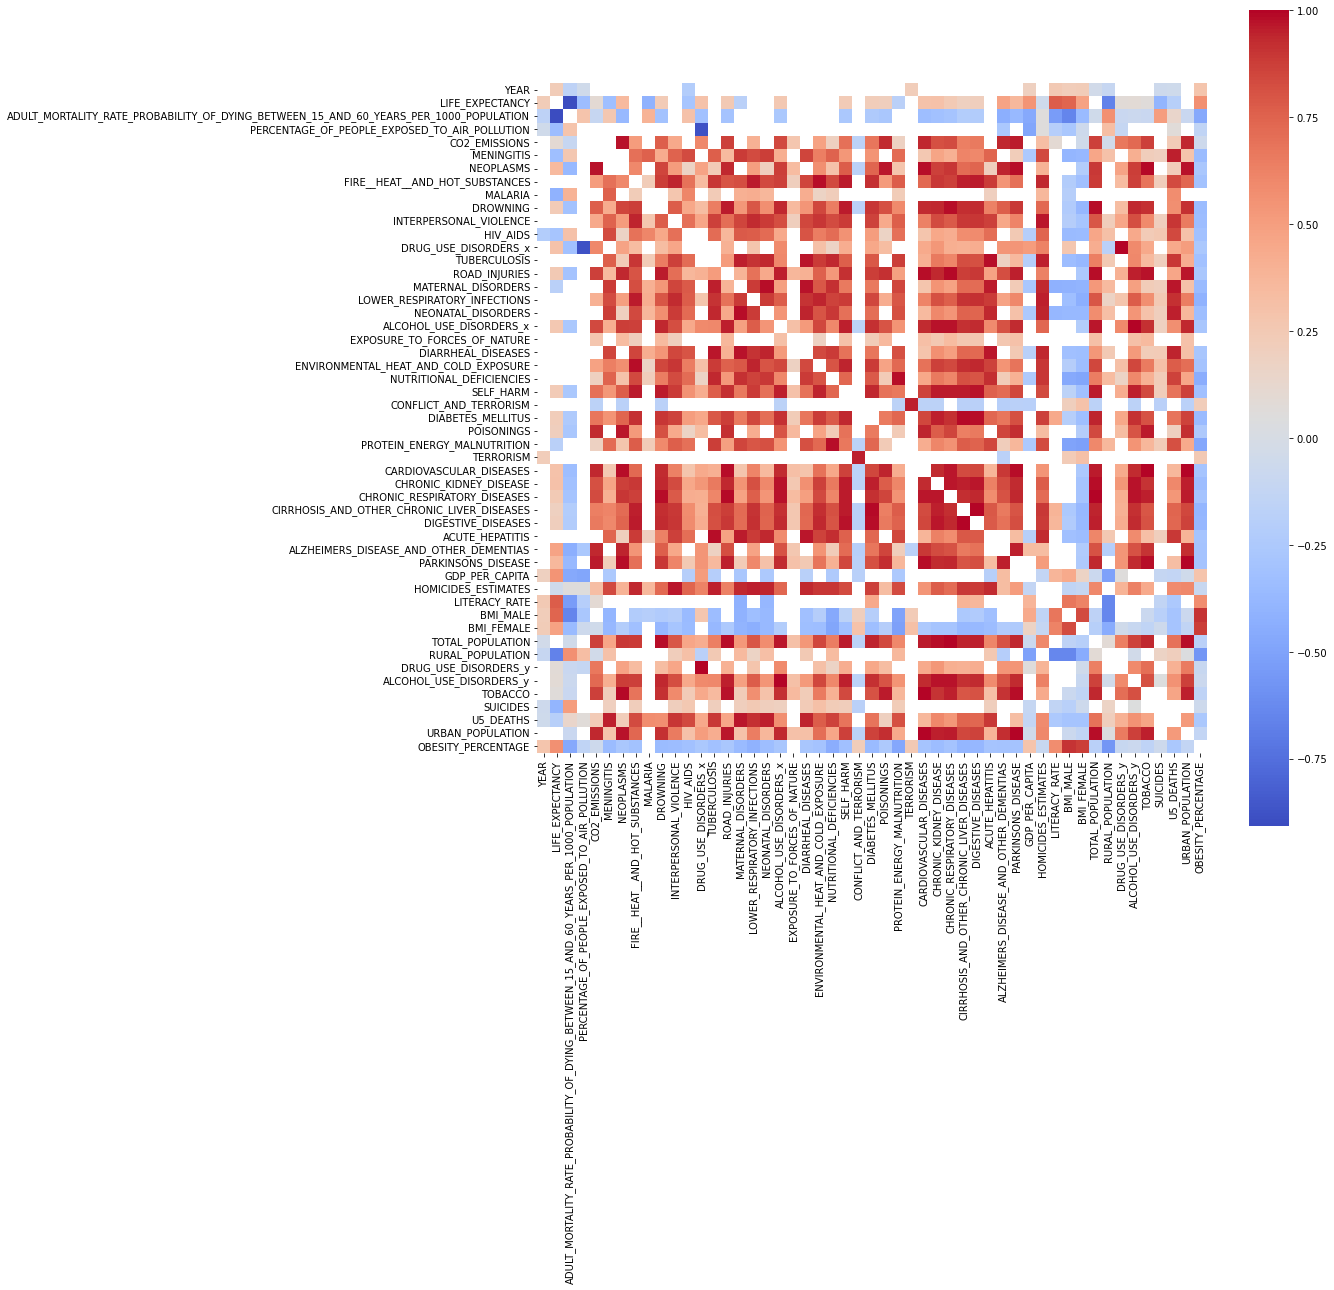

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate the Pearson correlation matrix for numeric columns
df_corrs = df.corr(method='pearson')

# Calculate p-values for each pair of variables
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1])

# Set statistical significance threshold (0.1%)
significance_level = 0.001
mask = pval > significance_level

# Plot the heatmap of statistically significant correlations
print("Correlation heatmap (only values with p < 0.1% shown):")
plt.figure(figsize=(15, 15))
sns.heatmap(df_corrs, mask=mask, square=True, cmap='coolwarm', annot=False)
plt.show()


In [41]:
# Drop variables that were originally excluded and visibly weak in the new matrix
df.drop([
    'PERCENTAGE_OF_PEOPLE_EXPOSED_TO_AIR_POLLUTION',
    'SUICIDES',
    'SUICIDESMIN',
    'SUICIDESMAX'
], axis=1, inplace=True, errors='ignore')


Linear Regression — MSE: 0.0067, R²: 0.9489


C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/2999843868.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['PREDICT'] = y_pred


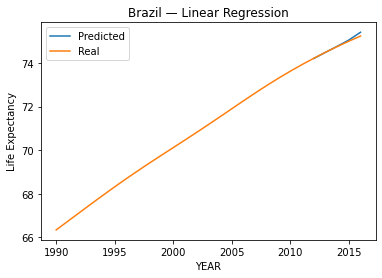

c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.13231e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.78461e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.96886e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.18563e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.56733e-18): result may 

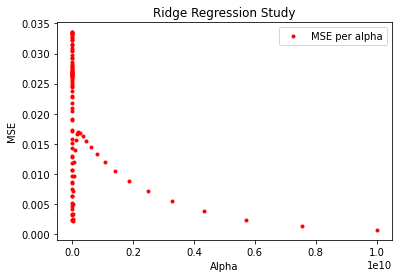

Best MSE: 0.0007 at alpha = 10000000000.0
Intercept                      :: 30.163800360
YEAR                           :: 0.000000000
CO2_EMISSIONS                  :: 0.000001454
GDP_PER_CAPITA                 :: 0.000000301
BMI_MALE                       :: 0.000000000
BMI_FEMALE                     :: 0.000000000
TOTAL_POPULATION               :: 0.000000392
RURAL_POPULATION               :: 0.000000000
DRUG_USE_DISORDERS_y           :: 0.000000011
ALCOHOL_USE_DISORDERS_y        :: -0.000000006
TOBACCO                        :: 0.000000051
U5_DEATHS                      :: 0.000000570
URBAN_POPULATION               :: -0.000000206
OBESITY_PERCENTAGE             :: 0.000000000
COUNTRY_NAME_Brazil            :: 0.000000000
R² Score: 0.9944


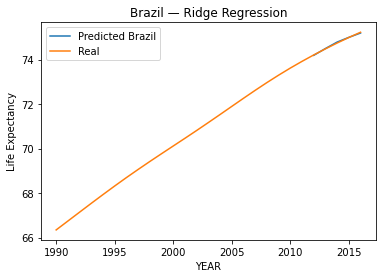

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/422766006.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018913770577661013, tolerance: 0.01875458144565216
  model = cd_fast.e

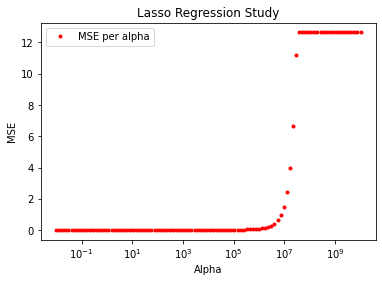

Best MSE: 0.0011 at alpha = 305.38555088334186
Intercept                      :: 30.467093789
YEAR                           :: 0.000000000
CO2_EMISSIONS                  :: 0.000001633
GDP_PER_CAPITA                 :: 0.000000000
BMI_MALE                       :: 0.000000000
BMI_FEMALE                     :: 0.000000000
TOTAL_POPULATION               :: 0.000000393
RURAL_POPULATION               :: 0.000000000
DRUG_USE_DISORDERS_y           :: 0.000000000
ALCOHOL_USE_DISORDERS_y        :: -0.000000000
TOBACCO                        :: 0.000000000
U5_DEATHS                      :: 0.000000000
URBAN_POPULATION               :: -0.000000209
OBESITY_PERCENTAGE             :: 0.000000000
COUNTRY_NAME_Brazil            :: 0.000000000
R² Score: 0.9917


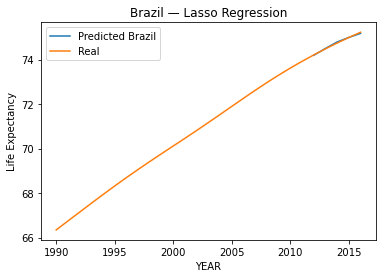

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/3467654115.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'


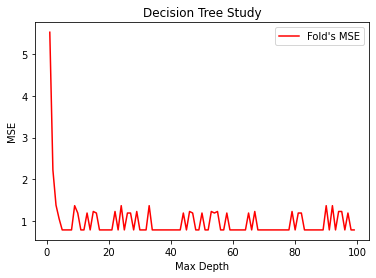

Best tree: max_depth = 5
R²: -5.0436779945881245


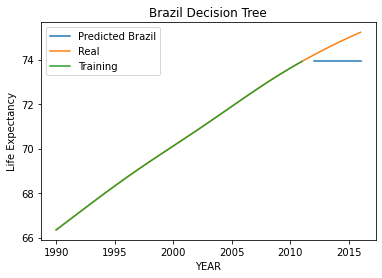

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/895512176.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'


Best max_features: 10
MSE: 0.9553


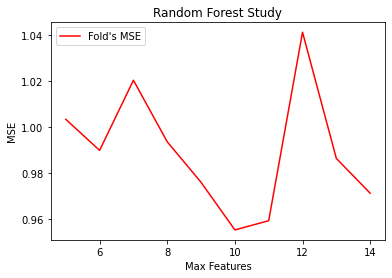

R²: -6.3218


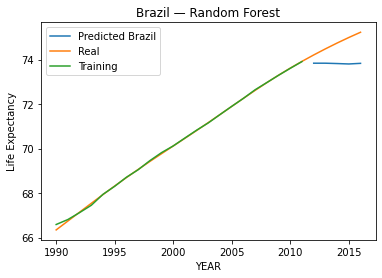

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/383235843.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'


Best GB learning rate = 1, MSE = 0.7885


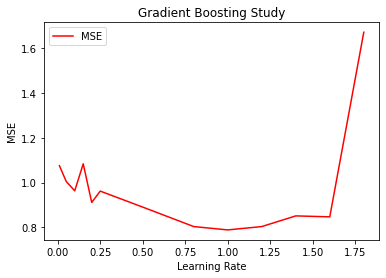

R²: -5.0436779945881245


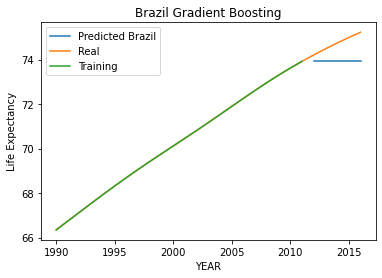

Linear Regression — MSE: 7.1367, R²: -4.8520


c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/3076277266.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/2999843868.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

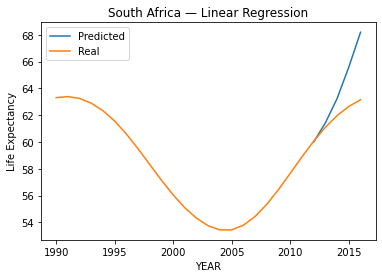

c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.67783e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.93429e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.19709e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.60533e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.15316e-17): result may 

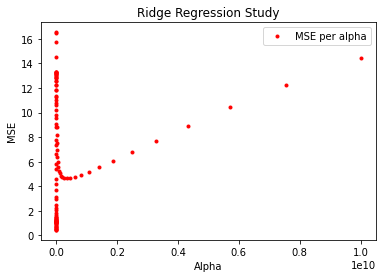

Best MSE: 0.4509 at alpha = 533.6699231206312
Intercept                      :: 93.252627985
YEAR                           :: -0.000583701
CO2_EMISSIONS                  :: 0.000009013
GDP_PER_CAPITA                 :: 0.000260275
BMI_MALE                       :: 0.000085534
BMI_FEMALE                     :: -0.000012436
TOTAL_POPULATION               :: -0.000000836
RURAL_POPULATION               :: -0.000164312
DRUG_USE_DISORDERS_y           :: -0.010337230
ALCOHOL_USE_DISORDERS_y        :: 0.040164686
TOBACCO                        :: -0.000753186
U5_DEATHS                      :: -0.000030486
URBAN_POPULATION               :: 0.000000624
OBESITY_PERCENTAGE             :: -0.000377285
COUNTRY_NAME_South Africa      :: 0.000000000
R² Score: 0.6302


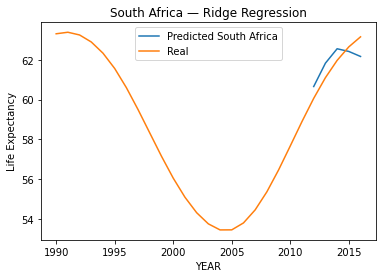

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/422766006.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'
c:\Users\Giovanna\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5469201594242667, tolerance: 0.042851560045652166
  model = cd_fast.en

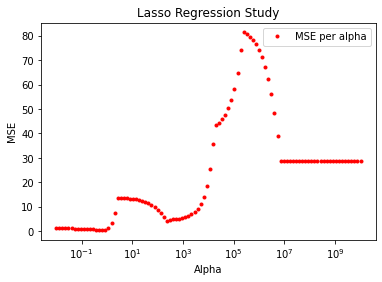

Best MSE: 0.4185 at alpha = 0.6579332246575682
Intercept                      :: 98.677475796
YEAR                           :: -0.000000000
CO2_EMISSIONS                  :: 0.000007950
GDP_PER_CAPITA                 :: 0.000284855
BMI_MALE                       :: 0.000000000
BMI_FEMALE                     :: -0.000000000
TOTAL_POPULATION               :: -0.000001409
RURAL_POPULATION               :: -0.000000000
DRUG_USE_DISORDERS_y           :: -0.000000000
ALCOHOL_USE_DISORDERS_y        :: 0.038205705
TOBACCO                        :: -0.000761499
U5_DEATHS                      :: -0.000042177
URBAN_POPULATION               :: 0.000001349
OBESITY_PERCENTAGE             :: -0.000000000
COUNTRY_NAME_South Africa      :: 0.000000000
R² Score: 0.6568


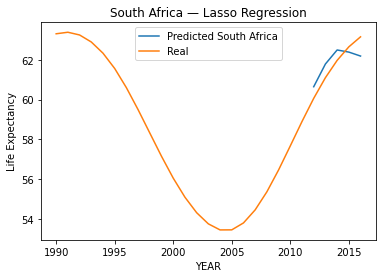

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/3467654115.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'


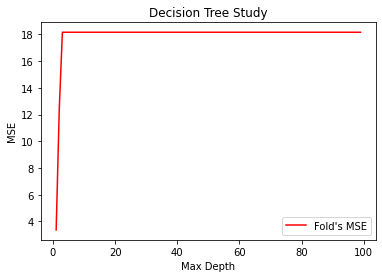

Best tree: max_depth = 1
R²: -1.759405019670956


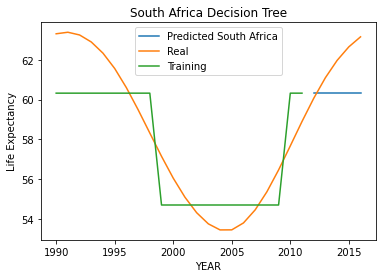

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/895512176.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'


Best max_features: 5
MSE: 10.9035


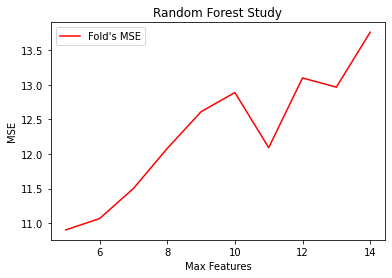

R²: -7.9407


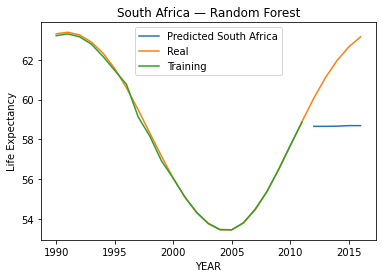

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/383235843.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'


Best GB learning rate = 1.8, MSE = 18.1676


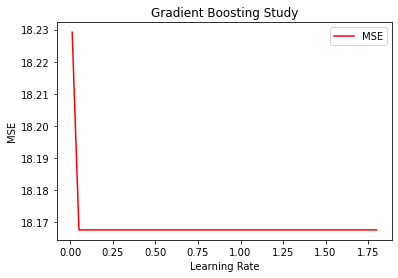

R²: -13.89724461313664


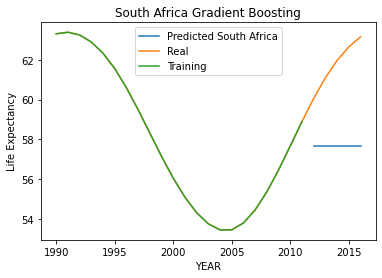

c:\Users\Giovanna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Giovanna\AppData\Local\Temp/ipykernel_8596/3076277266.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['valor_type'] = 'real'


In [53]:
def choose_countries(df, list_country):
    """Filter dataframe to include only selected countries"""
    return df[df['COUNTRY_NAME'].isin(list_country)]

def pipeline(df, list_country, year):
    df1 = choose_countries(df, list_country)

    # Drop columns with any missing values
    df1 = df1.dropna(axis=1)

    # One-hot encode country name
    df1 = pd.get_dummies(df1, columns=['COUNTRY_NAME'])

    # Run all model pipelines
    df2 = reg_lin(df1.copy(), list_country, year)
    df3 = ridge(df1.copy(), list_country, year)
    df4 = lasso(df1.copy(), list_country, year)
    df5 = decision_tree(df1.copy(), list_country, year)
    df6 = random_forest(df1.copy(), list_country, year)
    df7 = gradient_boosting(df1.copy(), list_country, year)
    
    df_resultados = pd.concat([df2, df3, df4, df5, df6, df7])

    # Clean dummy column names
    df_resultados.columns = df_resultados.columns.str.replace('COUNTRY_NAME_', '')
    df_resultados['Location'] = df_resultados[list_country].idxmax(axis=1)

    df_resultados.drop(columns=list_country, axis=1, inplace=True)
    return df_resultados

list_country_sets = [['Brazil'], ['South Africa']]
year = 2011

df_resultados = pd.DataFrame()

for country in list_country_sets:
    df_country = pipeline(df.copy(), country, year)
    df_resultados = pd.concat([df_resultados, df_country])

# Save to SQL table (if using PostgreSQL connection)
# create_table(df=df_resultados, tablename='results', conn=conn)

# Save modeling results to CSV
df_resultados.to_csv('../data/processed/modeling_results.csv', index=False)
